# Introduction
The Direxion Daily S&P Oil & Gas Exp. & Prod. Bull and Bear 3X Shares (GUSH) seek daily investment results, before fees and expenses, of 300%, or 300% of the inverse (or opposite), of the performance of the S&P Oil & Gas Exploration & Production Select Industry Index. There is no guarantee the funds will meet their stated investment objectives.
The goal of this project is providing a model to predicit intra-daye return of GUSH according to the the histical data of Gush and also crude oil price.    

## Comparing Results

I am compring differnt prediction models based on mean of absoulote error (MAE) and mean of square error over (MSE) the test set. The best model is random forest.  

In [138]:
compare_result(y_pred,y_test)

,MAE,RMSE
Model,,
DNN,0.7589,1.1006
knn,0.5968,0.9219
Random Forest,0.5849,0.9216
Lasso,0.5837,0.9139
Crude Avrage,0.5726,0.9072


### Libraries

In [238]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression,Lasso
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
get_ipython().magic('matplotlib inline')


In [158]:

# read Date

director = '/Users/z002df6/Downloads/'
file_name_gush = 'gush.csv'
file_name_oil = 'oil.csv'


df_gush = pd.read_csv(director+file_name_gush)
df_oil  = pd.read_csv(director+file_name_oil)
f = lambda x: ''.join([k for k in x if k != ' '])+'_gush'
df_gush =  df_gush.rename(f, axis='columns')
for l in range(1,5):
    df_gush['lag'+str(l)+'_gush'] = list(df_gush['Close_gush'])[l:]+[np.nan]*l

f = lambda x: ''.join([k for k in x if k != ' '])+'_oil'
df_oil  =  df_oil.rename(f, axis='columns')
df_oil['intra_r'] = (df_oil['Close_oil']-df_oil['Open_oil'])/df_oil['Open_oil']

df_gush['max_r'] = (df_gush['High_gush']-df_gush['Open_gush'])/df_gush['Open_gush']
df_gush['min_r'] = abs(df_gush['Low_gush']-df_gush['Open_gush'])/df_gush['Open_gush']
o = np.array(df_gush['Open_gush'][:-1])
c = np.array(df_gush['Close_gush'][1:])
df_gush['daily_r'] = list((o-c)/c)+[0]

h= pd.DataFrame((list(df_gush['max_r'])+list(-df_gush['min_r'])))

df = pd.concat([df_gush[:-1].reset_index(drop=True),
                df_oil[1:].reset_index(drop=True)],
                axis=1)

df.dropna(inplace=True,how= 'any', axis = 0)
df.to_csv('/Users/z002df6/Downloads/'+'gush_data.csv')
y_pred={}

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c37887dd0>,
      dtype=object)

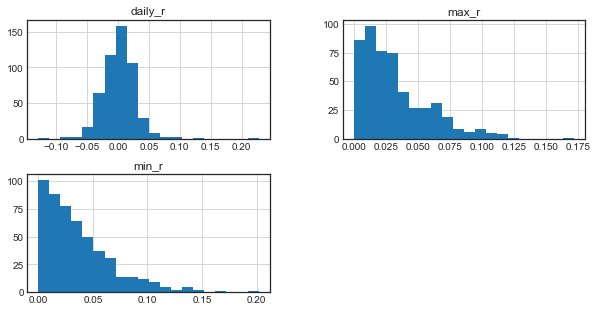

In [256]:
#plt.plot(range(70,100),np.percentile(np.array(df_gush['min_r']),range(70,100)))
#fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
df[['max_r','min_r','daily_r']].hist(bins=20, figsize=(10, 5))
#fig.show()

In [259]:
outputs = ['max_r','min_r']
inputs  = list(set(df.keys())-set(outputs+['Date_gush','Date_oil',
                                           'Low_gush',
                                           'Close_gush',
                                           'Volume_gush',
                                           'High_gush']))

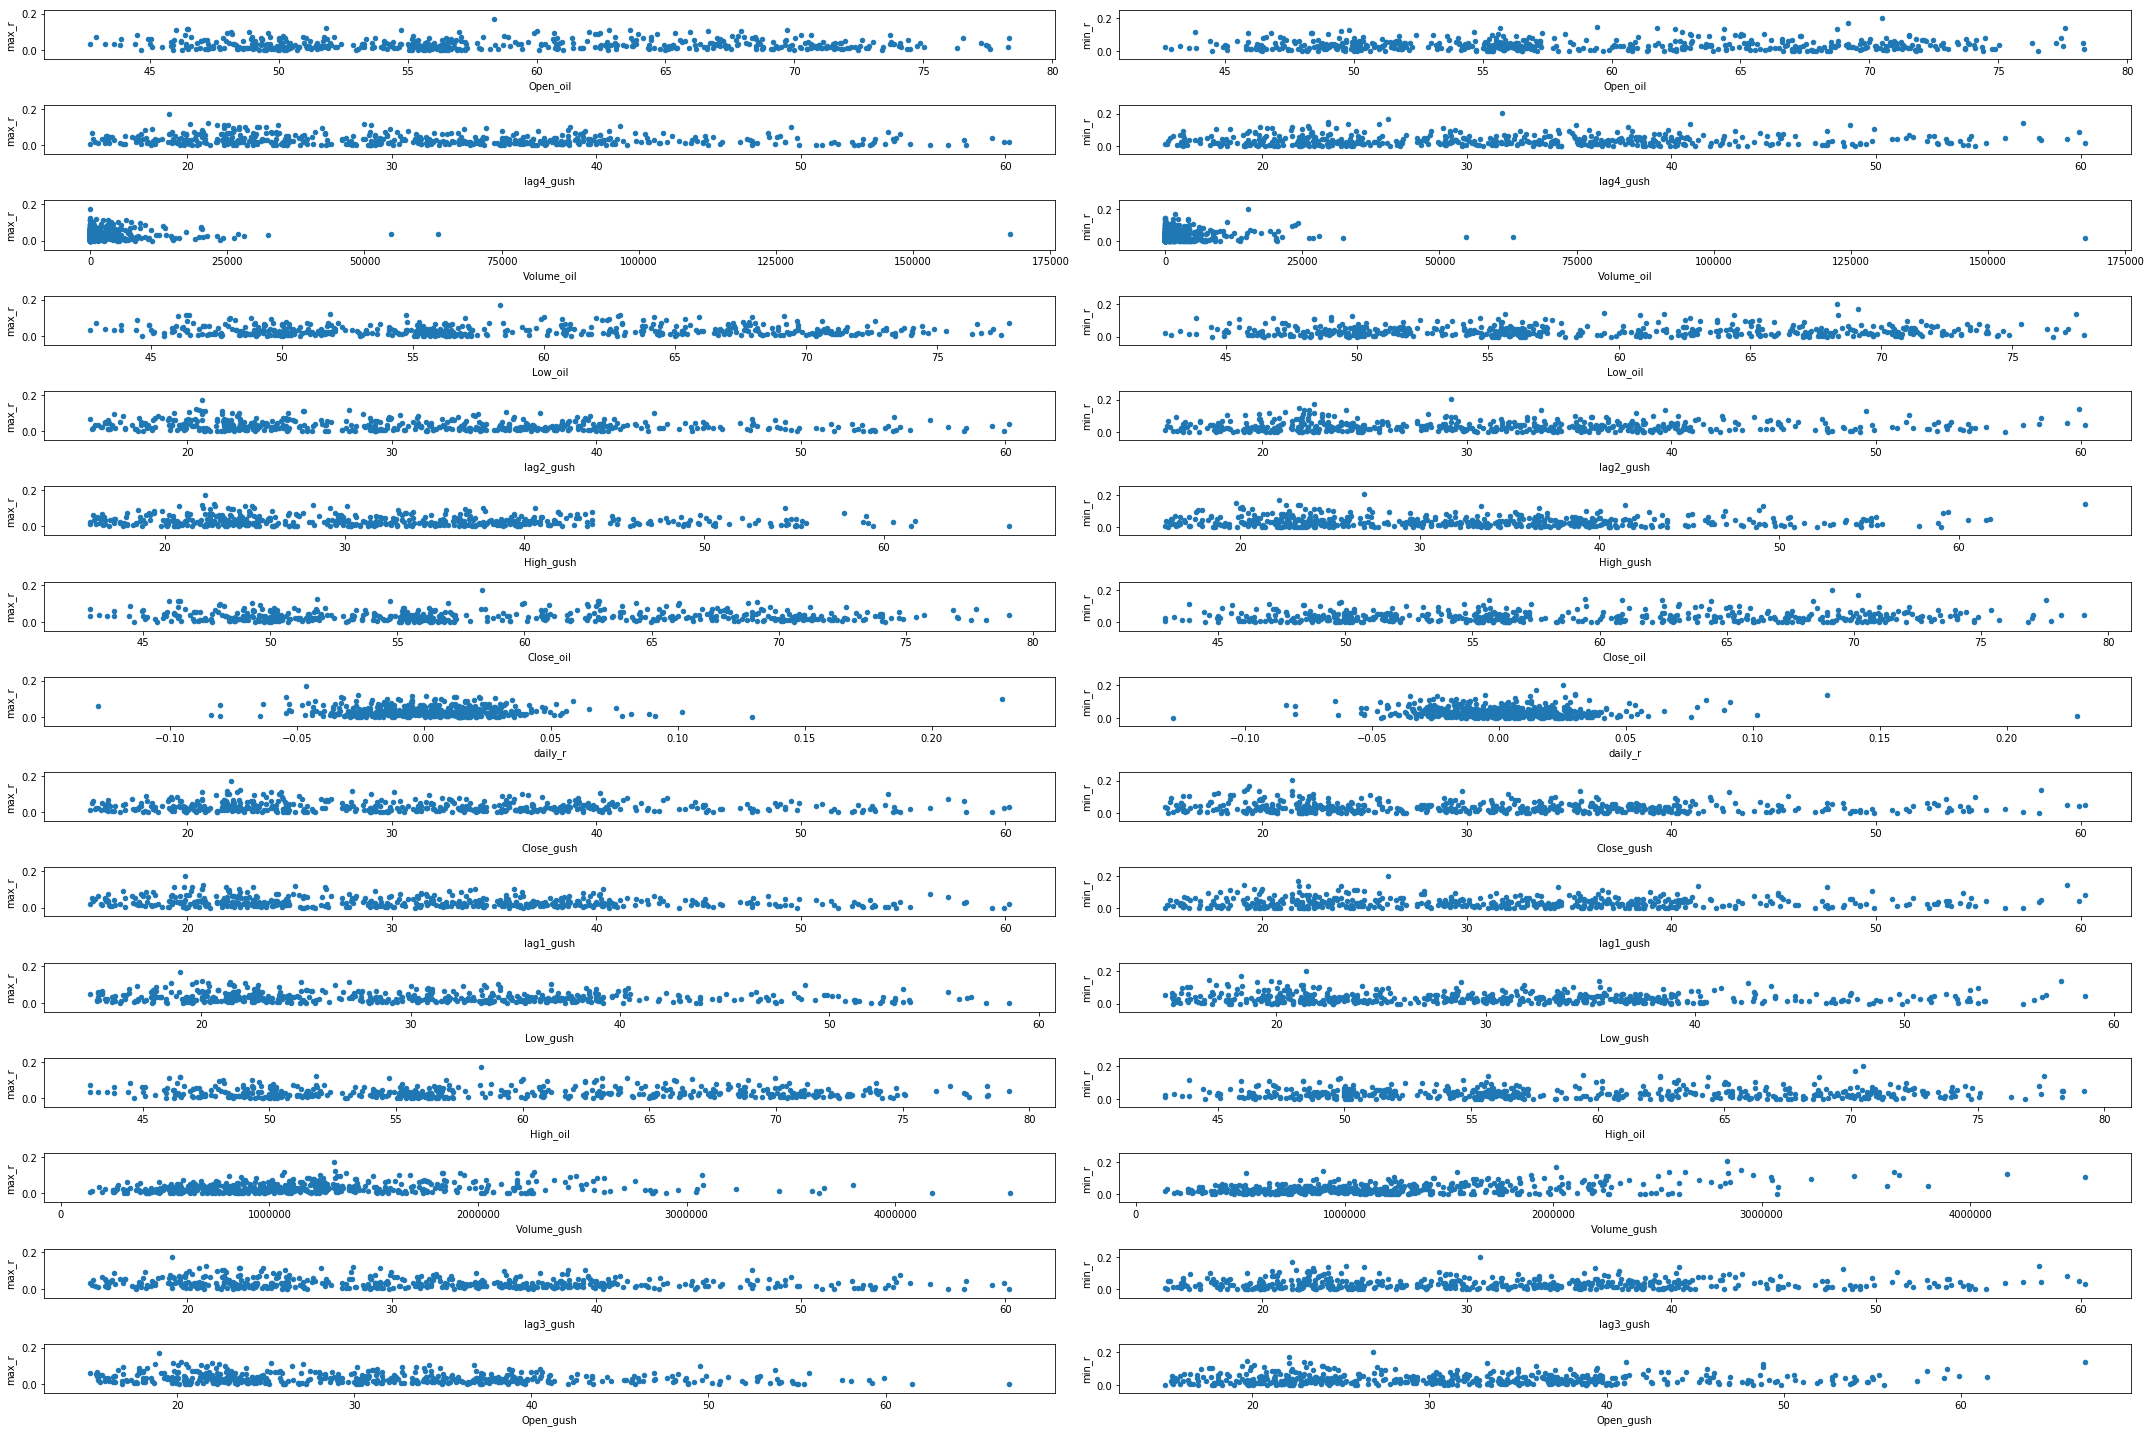

In [32]:
fig, axes = plt.subplots(nrows=len(inputs), ncols=len(outputs), figsize=(30, 20))
for i,nameo in enumerate(outputs):
    for j,namei in enumerate(inputs):
        ax = df.plot.scatter( namei,nameo,
                             ax = axes[j][i])
        ax.set(xlabel= namei, ylabel=nameo)
plt.tight_layout()
plt.show()

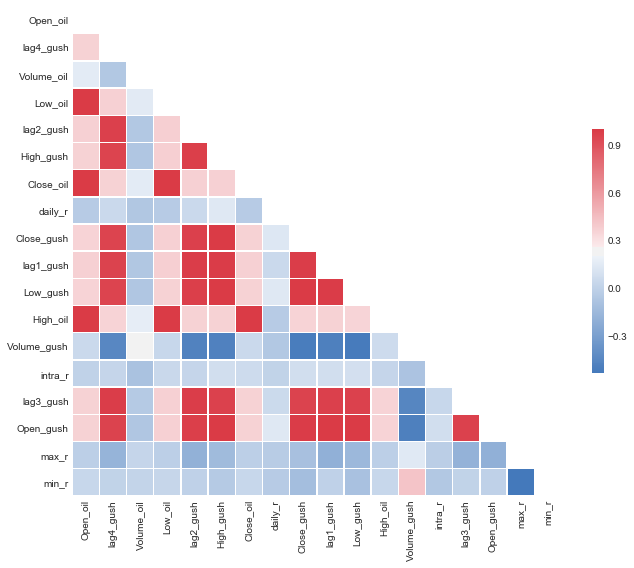

In [161]:
def CorrMtx(df, dropDuplicates = True):

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

crr = df[inputs+outputs].corr()

CorrMtx(crr, dropDuplicates = True)

In [166]:
auto_corr ={}
for l in range(1,7):
    for c in ['daily_r','min_r','max_r']:
        auto_corr[c]=auto_corr.get(c,[])+([df[c].autocorr(lag = l)]) 
pd.DataFrame(auto_corr)        
#CorrMtx(pd.DataFrame(auto_corr), dropDuplicates = False  )     
#df['daily_r'].autocorr()
#.apply(lambda x: x.autocorr)
#df['daily_r'].autocorr()



,daily_r,max_r,min_r
0,-0.065253,0.069401,0.074611
1,0.016216,0.036671,0.068198
2,0.001700,0.008474,0.058436
3,-0.091122,0.011925,0.074874
4,0.030032,0.042652,0.030831
5,0.020292,0.116922,-0.039855


In [261]:
from math import log

X = np.array(df[inputs])
y = np.array(df[outputs].applymap(lambda x: log(x+.00001)))
X,input_normlizer,input_de_normlizer = normalized(X)
y,ON,ODN = normalized(y)
ouput_normlizer    = lambda u : np.log(.00001+ON(u))
ouput_de_normlizer = lambda u :np.exp(ODN(u))-.00001
                                  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [260]:
def normalized(X):
    '''
    normilzed array X 
    '''
    avr  = X.mean(axis=0)
    avr  = avr[np.newaxis,:]
    X = X - np.repeat(avr, X.shape[0], axis=0)
    sd   = X.std(axis=0)
    sd  = sd[np.newaxis,:]
    X = X / np.repeat(sd, X.shape[0], axis=0)
    normlizer =lambda u: (u-np.repeat(avr, u.shape[0], axis=0))/np.repeat(sd, u.shape[0], axis=0)
    de_normlizer = lambda u: u*np.repeat(sd, u.shape[0], axis=0)+ np.repeat(avr, u.shape[0], axis=0)
    return X,normlizer, de_normlizer


In [244]:
pd.DataFrame(y,columns =outputs).describe().applymap(lambda x: round(x,3))

,max_r,min_r
count,513.000,513.000
mean,0.000,-0.000
std,1.001,1.001
min,-4.715,-3.873
25%,-0.250,-0.142
50%,0.202,0.246
75%,0.569,0.539
max,1.406,1.250


### Crude Average and Linear Model

In [262]:
avr = y_train.mean(axis=0)
avr = avr[np.newaxis,:]
y_pred['Crude Avrage'] = np.repeat(avr, y_test.shape[0], axis=0)
LM = Lasso(alpha=0.05)
LM.fit(X_train, y_train)
y_pred['Lasso'] = LM.predict(X_test)

### Random Forest and K-Nearest Neighbour

In [263]:
rf = RandomForestRegressor(n_estimators = 100, max_depth = 3)
# Train the model on training data
rf.fit(X_train, y_train)
y_pred['Random Forest'] = rf.predict(X_test)

In [264]:
knn = neighbors.KNeighborsRegressor(70, weights='distance')
knn.fit(X_train, y_train)
y_pred['knn'] = knn.predict(X_test)


### Deep Neural Net

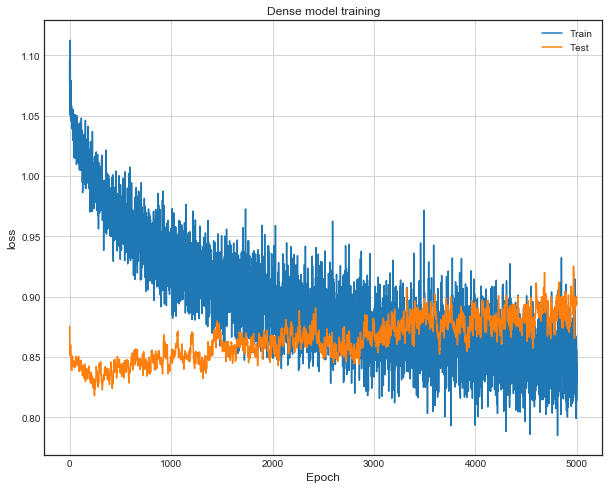

In [249]:
plt.figure(figsize=(10, 8))
plt.title("Dense model training", fontsize=12)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Test")
plt.grid("on")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend(loc="upper right")

In [265]:
DNN_model = Sequential()
DNN_model.add(Dense(100,input_dim=X_train.shape[1],init='uniform',activation='relu'))
DNN_model.add(Dropout(0.5))
DNN_model.add(Dense(50,init='uniform',activation='tanh'))
DNN_model.add(Dropout(0.5))
DNN_model.add(Dense(y_train.shape[1],init='uniform',activation='linear'))
DNN_model.summary()


# ### Fitting the DNN

mn = X_train.mean(axis=0)
sd = X_train.mean(axis=0)
#model.compile(loss='mean_absolute_error',optimizer='adam',metrics='[accuracy]')
DNN_model.compile(loss='mean_squared_error',optimizer='adam')
history = DNN_model.fit((X_train-mn)/sd,y_train,  
                    validation_data=((X_test-mn)/sd, y_test),
                    epochs =5000,
                    batch_size=100,
                    verbose=2)
y_pred['DNN'] = DNN_model.predict((X_test-mn)/sd)



/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", kernel_initializer="uniform", input_dim=12)`
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="tanh", kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="linear", kernel_initializer="uniform")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 100)               1300      
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_20 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 102       
Total params: 6,452
Trainable params: 6,452
Non-trainable params: 0
_________________________________________________________________
Train on 343 samples, validate on 170 samples
Epoch 1/5000
 - 0s - loss: 1.0036 - val_loss: 1.1001
Epoch 2/5000
 - 0s - loss: 1.0065 - val_l

 - 0s - loss: 0.8884 - val_loss: 1.0692
Epoch 134/5000
 - 0s - loss: 0.9095 - val_loss: 1.0760
Epoch 135/5000
 - 0s - loss: 0.9209 - val_loss: 1.0805
Epoch 136/5000
 - 0s - loss: 0.9101 - val_loss: 1.0760
Epoch 137/5000
 - 0s - loss: 0.9095 - val_loss: 1.0782
Epoch 138/5000
 - 0s - loss: 0.8977 - val_loss: 1.0807
Epoch 139/5000
 - 0s - loss: 0.9079 - val_loss: 1.0808
Epoch 140/5000
 - 0s - loss: 0.9020 - val_loss: 1.0788
Epoch 141/5000
 - 0s - loss: 0.9167 - val_loss: 1.0750
Epoch 142/5000
 - 0s - loss: 0.9068 - val_loss: 1.0729
Epoch 143/5000
 - 0s - loss: 0.8893 - val_loss: 1.0662
Epoch 144/5000
 - 0s - loss: 0.8965 - val_loss: 1.0642
Epoch 145/5000
 - 0s - loss: 0.9083 - val_loss: 1.0660
Epoch 146/5000
 - 0s - loss: 0.8828 - val_loss: 1.0678
Epoch 147/5000
 - 0s - loss: 0.9052 - val_loss: 1.0681
Epoch 148/5000
 - 0s - loss: 0.8979 - val_loss: 1.0683
Epoch 149/5000
 - 0s - loss: 0.9122 - val_loss: 1.0691
Epoch 150/5000
 - 0s - loss: 0.8924 - val_loss: 1.0713
Epoch 151/5000
 - 0s - lo

 - 0s - loss: 0.8646 - val_loss: 1.1116
Epoch 283/5000
 - 0s - loss: 0.8736 - val_loss: 1.1056
Epoch 284/5000
 - 0s - loss: 0.8667 - val_loss: 1.0987
Epoch 285/5000
 - 0s - loss: 0.8644 - val_loss: 1.0925
Epoch 286/5000
 - 0s - loss: 0.8940 - val_loss: 1.0881
Epoch 287/5000
 - 0s - loss: 0.8772 - val_loss: 1.0919
Epoch 288/5000
 - 0s - loss: 0.8779 - val_loss: 1.1008
Epoch 289/5000
 - 0s - loss: 0.8608 - val_loss: 1.1043
Epoch 290/5000
 - 0s - loss: 0.8740 - val_loss: 1.1062
Epoch 291/5000
 - 0s - loss: 0.8671 - val_loss: 1.1094
Epoch 292/5000
 - 0s - loss: 0.8650 - val_loss: 1.1162
Epoch 293/5000
 - 0s - loss: 0.8626 - val_loss: 1.1196
Epoch 294/5000
 - 0s - loss: 0.8740 - val_loss: 1.1151
Epoch 295/5000
 - 0s - loss: 0.8739 - val_loss: 1.1080
Epoch 296/5000
 - 0s - loss: 0.8510 - val_loss: 1.1026
Epoch 297/5000
 - 0s - loss: 0.8510 - val_loss: 1.1002
Epoch 298/5000
 - 0s - loss: 0.8634 - val_loss: 1.1011
Epoch 299/5000
 - 0s - loss: 0.8752 - val_loss: 1.0977
Epoch 300/5000
 - 0s - lo

 - 0s - loss: 0.8277 - val_loss: 1.1071
Epoch 432/5000
 - 0s - loss: 0.8517 - val_loss: 1.0998
Epoch 433/5000
 - 0s - loss: 0.8524 - val_loss: 1.0957
Epoch 434/5000
 - 0s - loss: 0.8422 - val_loss: 1.0880
Epoch 435/5000
 - 0s - loss: 0.8353 - val_loss: 1.0933
Epoch 436/5000
 - 0s - loss: 0.8443 - val_loss: 1.0994
Epoch 437/5000
 - 0s - loss: 0.8387 - val_loss: 1.1038
Epoch 438/5000
 - 0s - loss: 0.8165 - val_loss: 1.1083
Epoch 439/5000
 - 0s - loss: 0.8448 - val_loss: 1.1133
Epoch 440/5000
 - 0s - loss: 0.8502 - val_loss: 1.1124
Epoch 441/5000
 - 0s - loss: 0.8493 - val_loss: 1.1073
Epoch 442/5000
 - 0s - loss: 0.8314 - val_loss: 1.1108
Epoch 443/5000
 - 0s - loss: 0.8132 - val_loss: 1.1134
Epoch 444/5000
 - 0s - loss: 0.8458 - val_loss: 1.1077
Epoch 445/5000
 - 0s - loss: 0.8343 - val_loss: 1.1059
Epoch 446/5000
 - 0s - loss: 0.8081 - val_loss: 1.1120
Epoch 447/5000
 - 0s - loss: 0.8461 - val_loss: 1.1146
Epoch 448/5000
 - 0s - loss: 0.8384 - val_loss: 1.1202
Epoch 449/5000
 - 0s - lo

 - 0s - loss: 0.8586 - val_loss: 1.1196
Epoch 581/5000
 - 0s - loss: 0.8356 - val_loss: 1.1209
Epoch 582/5000
 - 0s - loss: 0.8275 - val_loss: 1.1213
Epoch 583/5000
 - 0s - loss: 0.8174 - val_loss: 1.1175
Epoch 584/5000
 - 0s - loss: 0.8205 - val_loss: 1.1133
Epoch 585/5000
 - 0s - loss: 0.8515 - val_loss: 1.1080
Epoch 586/5000
 - 0s - loss: 0.8416 - val_loss: 1.1045
Epoch 587/5000
 - 0s - loss: 0.8092 - val_loss: 1.1065
Epoch 588/5000
 - 0s - loss: 0.7941 - val_loss: 1.1147
Epoch 589/5000
 - 0s - loss: 0.8028 - val_loss: 1.1296
Epoch 590/5000
 - 0s - loss: 0.8176 - val_loss: 1.1385
Epoch 591/5000
 - 0s - loss: 0.8243 - val_loss: 1.1303
Epoch 592/5000
 - 0s - loss: 0.8377 - val_loss: 1.1288
Epoch 593/5000
 - 0s - loss: 0.8368 - val_loss: 1.1337
Epoch 594/5000
 - 0s - loss: 0.8249 - val_loss: 1.1268
Epoch 595/5000
 - 0s - loss: 0.8067 - val_loss: 1.1284
Epoch 596/5000
 - 0s - loss: 0.8173 - val_loss: 1.1310
Epoch 597/5000
 - 0s - loss: 0.8190 - val_loss: 1.1378
Epoch 598/5000
 - 0s - lo

 - 0s - loss: 0.8372 - val_loss: 1.1279
Epoch 730/5000
 - 0s - loss: 0.7699 - val_loss: 1.1283
Epoch 731/5000
 - 0s - loss: 0.7966 - val_loss: 1.1265
Epoch 732/5000
 - 0s - loss: 0.7863 - val_loss: 1.1239
Epoch 733/5000
 - 0s - loss: 0.8244 - val_loss: 1.1234
Epoch 734/5000
 - 0s - loss: 0.7958 - val_loss: 1.1228
Epoch 735/5000
 - 0s - loss: 0.8089 - val_loss: 1.1180
Epoch 736/5000
 - 0s - loss: 0.7832 - val_loss: 1.1215
Epoch 737/5000
 - 0s - loss: 0.7986 - val_loss: 1.1308
Epoch 738/5000
 - 0s - loss: 0.8050 - val_loss: 1.1273
Epoch 739/5000
 - 0s - loss: 0.8118 - val_loss: 1.1242
Epoch 740/5000
 - 0s - loss: 0.7849 - val_loss: 1.1243
Epoch 741/5000
 - 0s - loss: 0.8206 - val_loss: 1.1160
Epoch 742/5000
 - 0s - loss: 0.8301 - val_loss: 1.1176
Epoch 743/5000
 - 0s - loss: 0.7651 - val_loss: 1.1264
Epoch 744/5000
 - 0s - loss: 0.7899 - val_loss: 1.1364
Epoch 745/5000
 - 0s - loss: 0.7920 - val_loss: 1.1435
Epoch 746/5000
 - 0s - loss: 0.7848 - val_loss: 1.1500
Epoch 747/5000
 - 0s - lo

 - 0s - loss: 0.8102 - val_loss: 1.1388
Epoch 879/5000
 - 0s - loss: 0.7692 - val_loss: 1.1291
Epoch 880/5000
 - 0s - loss: 0.8071 - val_loss: 1.1259
Epoch 881/5000
 - 0s - loss: 0.7892 - val_loss: 1.1230
Epoch 882/5000
 - 0s - loss: 0.7899 - val_loss: 1.1278
Epoch 883/5000
 - 0s - loss: 0.8015 - val_loss: 1.1337
Epoch 884/5000
 - 0s - loss: 0.7762 - val_loss: 1.1359
Epoch 885/5000
 - 0s - loss: 0.7935 - val_loss: 1.1367
Epoch 886/5000
 - 0s - loss: 0.8001 - val_loss: 1.1352
Epoch 887/5000
 - 0s - loss: 0.7684 - val_loss: 1.1371
Epoch 888/5000
 - 0s - loss: 0.7743 - val_loss: 1.1443
Epoch 889/5000
 - 0s - loss: 0.8010 - val_loss: 1.1478
Epoch 890/5000
 - 0s - loss: 0.8184 - val_loss: 1.1508
Epoch 891/5000
 - 0s - loss: 0.7789 - val_loss: 1.1494
Epoch 892/5000
 - 0s - loss: 0.7710 - val_loss: 1.1440
Epoch 893/5000
 - 0s - loss: 0.7747 - val_loss: 1.1427
Epoch 894/5000
 - 0s - loss: 0.7810 - val_loss: 1.1516
Epoch 895/5000
 - 0s - loss: 0.7570 - val_loss: 1.1626
Epoch 896/5000
 - 0s - lo

Epoch 1027/5000
 - 0s - loss: 0.7379 - val_loss: 1.1359
Epoch 1028/5000
 - 0s - loss: 0.7544 - val_loss: 1.1375
Epoch 1029/5000
 - 0s - loss: 0.7663 - val_loss: 1.1418
Epoch 1030/5000
 - 0s - loss: 0.7387 - val_loss: 1.1399
Epoch 1031/5000
 - 0s - loss: 0.7652 - val_loss: 1.1276
Epoch 1032/5000
 - 0s - loss: 0.7757 - val_loss: 1.1279
Epoch 1033/5000
 - 0s - loss: 0.7838 - val_loss: 1.1301
Epoch 1034/5000
 - 0s - loss: 0.7563 - val_loss: 1.1359
Epoch 1035/5000
 - 0s - loss: 0.7754 - val_loss: 1.1357
Epoch 1036/5000
 - 0s - loss: 0.7615 - val_loss: 1.1374
Epoch 1037/5000
 - 0s - loss: 0.7996 - val_loss: 1.1385
Epoch 1038/5000
 - 0s - loss: 0.7727 - val_loss: 1.1376
Epoch 1039/5000
 - 0s - loss: 0.8039 - val_loss: 1.1444
Epoch 1040/5000
 - 0s - loss: 0.7722 - val_loss: 1.1452
Epoch 1041/5000
 - 0s - loss: 0.7464 - val_loss: 1.1310
Epoch 1042/5000
 - 0s - loss: 0.7832 - val_loss: 1.1297
Epoch 1043/5000
 - 0s - loss: 0.7644 - val_loss: 1.1369
Epoch 1044/5000
 - 0s - loss: 0.7985 - val_loss:

Epoch 1174/5000
 - 0s - loss: 0.7919 - val_loss: 1.1573
Epoch 1175/5000
 - 0s - loss: 0.7789 - val_loss: 1.1548
Epoch 1176/5000
 - 0s - loss: 0.7782 - val_loss: 1.1506
Epoch 1177/5000
 - 0s - loss: 0.7709 - val_loss: 1.1409
Epoch 1178/5000
 - 0s - loss: 0.7786 - val_loss: 1.1381
Epoch 1179/5000
 - 0s - loss: 0.7758 - val_loss: 1.1380
Epoch 1180/5000
 - 0s - loss: 0.7519 - val_loss: 1.1396
Epoch 1181/5000
 - 0s - loss: 0.7420 - val_loss: 1.1317
Epoch 1182/5000
 - 0s - loss: 0.7604 - val_loss: 1.1325
Epoch 1183/5000
 - 0s - loss: 0.7683 - val_loss: 1.1311
Epoch 1184/5000
 - 0s - loss: 0.7760 - val_loss: 1.1231
Epoch 1185/5000
 - 0s - loss: 0.7687 - val_loss: 1.1285
Epoch 1186/5000
 - 0s - loss: 0.7736 - val_loss: 1.1335
Epoch 1187/5000
 - 0s - loss: 0.7681 - val_loss: 1.1417
Epoch 1188/5000
 - 0s - loss: 0.7830 - val_loss: 1.1396
Epoch 1189/5000
 - 0s - loss: 0.7729 - val_loss: 1.1337
Epoch 1190/5000
 - 0s - loss: 0.7827 - val_loss: 1.1271
Epoch 1191/5000
 - 0s - loss: 0.7524 - val_loss:

Epoch 1321/5000
 - 0s - loss: 0.7673 - val_loss: 1.1503
Epoch 1322/5000
 - 0s - loss: 0.7589 - val_loss: 1.1487
Epoch 1323/5000
 - 0s - loss: 0.7237 - val_loss: 1.1489
Epoch 1324/5000
 - 0s - loss: 0.7405 - val_loss: 1.1477
Epoch 1325/5000
 - 0s - loss: 0.7288 - val_loss: 1.1335
Epoch 1326/5000
 - 0s - loss: 0.7577 - val_loss: 1.1229
Epoch 1327/5000
 - 0s - loss: 0.7412 - val_loss: 1.1291
Epoch 1328/5000
 - 0s - loss: 0.7643 - val_loss: 1.1269
Epoch 1329/5000
 - 0s - loss: 0.7335 - val_loss: 1.1316
Epoch 1330/5000
 - 0s - loss: 0.7905 - val_loss: 1.1417
Epoch 1331/5000
 - 0s - loss: 0.8101 - val_loss: 1.1278
Epoch 1332/5000
 - 0s - loss: 0.7184 - val_loss: 1.1134
Epoch 1333/5000
 - 0s - loss: 0.8002 - val_loss: 1.1123
Epoch 1334/5000
 - 0s - loss: 0.7645 - val_loss: 1.1261
Epoch 1335/5000
 - 0s - loss: 0.7623 - val_loss: 1.1343
Epoch 1336/5000
 - 0s - loss: 0.7712 - val_loss: 1.1369
Epoch 1337/5000
 - 0s - loss: 0.7473 - val_loss: 1.1328
Epoch 1338/5000
 - 0s - loss: 0.7536 - val_loss:

Epoch 1468/5000
 - 0s - loss: 0.7408 - val_loss: 1.1477
Epoch 1469/5000
 - 0s - loss: 0.7459 - val_loss: 1.1495
Epoch 1470/5000
 - 0s - loss: 0.6982 - val_loss: 1.1511
Epoch 1471/5000
 - 0s - loss: 0.7157 - val_loss: 1.1534
Epoch 1472/5000
 - 0s - loss: 0.7401 - val_loss: 1.1736
Epoch 1473/5000
 - 0s - loss: 0.7909 - val_loss: 1.1792
Epoch 1474/5000
 - 0s - loss: 0.7258 - val_loss: 1.1820
Epoch 1475/5000
 - 0s - loss: 0.7425 - val_loss: 1.1734
Epoch 1476/5000
 - 0s - loss: 0.7145 - val_loss: 1.1679
Epoch 1477/5000
 - 0s - loss: 0.7053 - val_loss: 1.1637
Epoch 1478/5000
 - 0s - loss: 0.7406 - val_loss: 1.1643
Epoch 1479/5000
 - 0s - loss: 0.7420 - val_loss: 1.1642
Epoch 1480/5000
 - 0s - loss: 0.7618 - val_loss: 1.1650
Epoch 1481/5000
 - 0s - loss: 0.7224 - val_loss: 1.1608
Epoch 1482/5000
 - 0s - loss: 0.7486 - val_loss: 1.1629
Epoch 1483/5000
 - 0s - loss: 0.7444 - val_loss: 1.1583
Epoch 1484/5000
 - 0s - loss: 0.7211 - val_loss: 1.1566
Epoch 1485/5000
 - 0s - loss: 0.7250 - val_loss:

Epoch 1615/5000
 - 0s - loss: 0.7626 - val_loss: 1.1782
Epoch 1616/5000
 - 0s - loss: 0.7906 - val_loss: 1.1790
Epoch 1617/5000
 - 0s - loss: 0.7527 - val_loss: 1.1762
Epoch 1618/5000
 - 0s - loss: 0.7616 - val_loss: 1.1719
Epoch 1619/5000
 - 0s - loss: 0.7312 - val_loss: 1.1639
Epoch 1620/5000
 - 0s - loss: 0.7501 - val_loss: 1.1552
Epoch 1621/5000
 - 0s - loss: 0.7303 - val_loss: 1.1687
Epoch 1622/5000
 - 0s - loss: 0.7426 - val_loss: 1.1753
Epoch 1623/5000
 - 0s - loss: 0.7448 - val_loss: 1.1770
Epoch 1624/5000
 - 0s - loss: 0.7415 - val_loss: 1.1759
Epoch 1625/5000
 - 0s - loss: 0.7928 - val_loss: 1.1726
Epoch 1626/5000
 - 0s - loss: 0.7516 - val_loss: 1.1733
Epoch 1627/5000
 - 0s - loss: 0.7770 - val_loss: 1.1737
Epoch 1628/5000
 - 0s - loss: 0.7356 - val_loss: 1.1621
Epoch 1629/5000
 - 0s - loss: 0.7666 - val_loss: 1.1499
Epoch 1630/5000
 - 0s - loss: 0.7463 - val_loss: 1.1434
Epoch 1631/5000
 - 0s - loss: 0.7436 - val_loss: 1.1372
Epoch 1632/5000
 - 0s - loss: 0.7260 - val_loss:

Epoch 1762/5000
 - 0s - loss: 0.7144 - val_loss: 1.1719
Epoch 1763/5000
 - 0s - loss: 0.7633 - val_loss: 1.1688
Epoch 1764/5000
 - 0s - loss: 0.7292 - val_loss: 1.1682
Epoch 1765/5000
 - 0s - loss: 0.7031 - val_loss: 1.1786
Epoch 1766/5000
 - 0s - loss: 0.7402 - val_loss: 1.1871
Epoch 1767/5000
 - 0s - loss: 0.7266 - val_loss: 1.1915
Epoch 1768/5000
 - 0s - loss: 0.7153 - val_loss: 1.1850
Epoch 1769/5000
 - 0s - loss: 0.7435 - val_loss: 1.1842
Epoch 1770/5000
 - 0s - loss: 0.7507 - val_loss: 1.1911
Epoch 1771/5000
 - 0s - loss: 0.7464 - val_loss: 1.1964
Epoch 1772/5000
 - 0s - loss: 0.7418 - val_loss: 1.1849
Epoch 1773/5000
 - 0s - loss: 0.7024 - val_loss: 1.1696
Epoch 1774/5000
 - 0s - loss: 0.7099 - val_loss: 1.1628
Epoch 1775/5000
 - 0s - loss: 0.7388 - val_loss: 1.1584
Epoch 1776/5000
 - 0s - loss: 0.7075 - val_loss: 1.1616
Epoch 1777/5000
 - 0s - loss: 0.7647 - val_loss: 1.1593
Epoch 1778/5000
 - 0s - loss: 0.7586 - val_loss: 1.1544
Epoch 1779/5000
 - 0s - loss: 0.7561 - val_loss:

Epoch 1909/5000
 - 0s - loss: 0.7563 - val_loss: 1.1954
Epoch 1910/5000
 - 0s - loss: 0.7628 - val_loss: 1.1785
Epoch 1911/5000
 - 0s - loss: 0.7556 - val_loss: 1.1721
Epoch 1912/5000
 - 0s - loss: 0.7934 - val_loss: 1.1752
Epoch 1913/5000
 - 0s - loss: 0.7595 - val_loss: 1.1720
Epoch 1914/5000
 - 0s - loss: 0.7553 - val_loss: 1.1779
Epoch 1915/5000
 - 0s - loss: 0.7525 - val_loss: 1.1814
Epoch 1916/5000
 - 0s - loss: 0.7292 - val_loss: 1.1784
Epoch 1917/5000
 - 0s - loss: 0.7470 - val_loss: 1.1763
Epoch 1918/5000
 - 0s - loss: 0.6937 - val_loss: 1.1662
Epoch 1919/5000
 - 0s - loss: 0.7196 - val_loss: 1.1688
Epoch 1920/5000
 - 0s - loss: 0.7561 - val_loss: 1.1737
Epoch 1921/5000
 - 0s - loss: 0.7564 - val_loss: 1.1766
Epoch 1922/5000
 - 0s - loss: 0.7410 - val_loss: 1.1790
Epoch 1923/5000
 - 0s - loss: 0.7525 - val_loss: 1.1791
Epoch 1924/5000
 - 0s - loss: 0.7023 - val_loss: 1.1843
Epoch 1925/5000
 - 0s - loss: 0.7324 - val_loss: 1.1845
Epoch 1926/5000
 - 0s - loss: 0.7891 - val_loss:

Epoch 2056/5000
 - 0s - loss: 0.7245 - val_loss: 1.2033
Epoch 2057/5000
 - 0s - loss: 0.7544 - val_loss: 1.2063
Epoch 2058/5000
 - 0s - loss: 0.7417 - val_loss: 1.2058
Epoch 2059/5000
 - 0s - loss: 0.7324 - val_loss: 1.1991
Epoch 2060/5000
 - 0s - loss: 0.7352 - val_loss: 1.2011
Epoch 2061/5000
 - 0s - loss: 0.7168 - val_loss: 1.2109
Epoch 2062/5000
 - 0s - loss: 0.7659 - val_loss: 1.2174
Epoch 2063/5000
 - 0s - loss: 0.7674 - val_loss: 1.2211
Epoch 2064/5000
 - 0s - loss: 0.7476 - val_loss: 1.2141
Epoch 2065/5000
 - 0s - loss: 0.7935 - val_loss: 1.1894
Epoch 2066/5000
 - 0s - loss: 0.7639 - val_loss: 1.1699
Epoch 2067/5000
 - 0s - loss: 0.7555 - val_loss: 1.1640
Epoch 2068/5000
 - 0s - loss: 0.7570 - val_loss: 1.1599
Epoch 2069/5000
 - 0s - loss: 0.7320 - val_loss: 1.1633
Epoch 2070/5000
 - 0s - loss: 0.7183 - val_loss: 1.1706
Epoch 2071/5000
 - 0s - loss: 0.7685 - val_loss: 1.1731
Epoch 2072/5000
 - 0s - loss: 0.7165 - val_loss: 1.1762
Epoch 2073/5000
 - 0s - loss: 0.7472 - val_loss:

Epoch 2203/5000
 - 0s - loss: 0.6990 - val_loss: 1.1901
Epoch 2204/5000
 - 0s - loss: 0.7401 - val_loss: 1.1863
Epoch 2205/5000
 - 0s - loss: 0.7053 - val_loss: 1.1741
Epoch 2206/5000
 - 0s - loss: 0.7288 - val_loss: 1.1465
Epoch 2207/5000
 - 0s - loss: 0.7624 - val_loss: 1.1351
Epoch 2208/5000
 - 0s - loss: 0.7630 - val_loss: 1.1451
Epoch 2209/5000
 - 0s - loss: 0.7351 - val_loss: 1.1478
Epoch 2210/5000
 - 0s - loss: 0.7083 - val_loss: 1.1528
Epoch 2211/5000
 - 0s - loss: 0.7136 - val_loss: 1.1638
Epoch 2212/5000
 - 0s - loss: 0.7419 - val_loss: 1.1656
Epoch 2213/5000
 - 0s - loss: 0.7117 - val_loss: 1.1903
Epoch 2214/5000
 - 0s - loss: 0.6914 - val_loss: 1.2241
Epoch 2215/5000
 - 0s - loss: 0.7265 - val_loss: 1.2348
Epoch 2216/5000
 - 0s - loss: 0.7402 - val_loss: 1.2239
Epoch 2217/5000
 - 0s - loss: 0.6968 - val_loss: 1.2020
Epoch 2218/5000
 - 0s - loss: 0.7190 - val_loss: 1.1904
Epoch 2219/5000
 - 0s - loss: 0.7693 - val_loss: 1.1734
Epoch 2220/5000
 - 0s - loss: 0.7289 - val_loss:

Epoch 2350/5000
 - 0s - loss: 0.7158 - val_loss: 1.2127
Epoch 2351/5000
 - 0s - loss: 0.6877 - val_loss: 1.2016
Epoch 2352/5000
 - 0s - loss: 0.7180 - val_loss: 1.1874
Epoch 2353/5000
 - 0s - loss: 0.7029 - val_loss: 1.1860
Epoch 2354/5000
 - 0s - loss: 0.6882 - val_loss: 1.1906
Epoch 2355/5000
 - 0s - loss: 0.7524 - val_loss: 1.1801
Epoch 2356/5000
 - 0s - loss: 0.6989 - val_loss: 1.1865
Epoch 2357/5000
 - 0s - loss: 0.7223 - val_loss: 1.1865
Epoch 2358/5000
 - 0s - loss: 0.7043 - val_loss: 1.1868
Epoch 2359/5000
 - 0s - loss: 0.7391 - val_loss: 1.1880
Epoch 2360/5000
 - 0s - loss: 0.7022 - val_loss: 1.1806
Epoch 2361/5000
 - 0s - loss: 0.7384 - val_loss: 1.1775
Epoch 2362/5000
 - 0s - loss: 0.7698 - val_loss: 1.1656
Epoch 2363/5000
 - 0s - loss: 0.7447 - val_loss: 1.1577
Epoch 2364/5000
 - 0s - loss: 0.7585 - val_loss: 1.1630
Epoch 2365/5000
 - 0s - loss: 0.7475 - val_loss: 1.1654
Epoch 2366/5000
 - 0s - loss: 0.7490 - val_loss: 1.1666
Epoch 2367/5000
 - 0s - loss: 0.7236 - val_loss:

Epoch 2497/5000
 - 0s - loss: 0.7283 - val_loss: 1.2078
Epoch 2498/5000
 - 0s - loss: 0.7047 - val_loss: 1.2040
Epoch 2499/5000
 - 0s - loss: 0.7066 - val_loss: 1.1947
Epoch 2500/5000
 - 0s - loss: 0.7250 - val_loss: 1.1914
Epoch 2501/5000
 - 0s - loss: 0.7017 - val_loss: 1.2035
Epoch 2502/5000
 - 0s - loss: 0.7233 - val_loss: 1.2065
Epoch 2503/5000
 - 0s - loss: 0.7114 - val_loss: 1.1965
Epoch 2504/5000
 - 0s - loss: 0.7244 - val_loss: 1.1929
Epoch 2505/5000
 - 0s - loss: 0.7366 - val_loss: 1.1952
Epoch 2506/5000
 - 0s - loss: 0.7416 - val_loss: 1.1957
Epoch 2507/5000
 - 0s - loss: 0.7304 - val_loss: 1.1953
Epoch 2508/5000
 - 0s - loss: 0.7907 - val_loss: 1.1975
Epoch 2509/5000
 - 0s - loss: 0.7433 - val_loss: 1.1910
Epoch 2510/5000
 - 0s - loss: 0.7366 - val_loss: 1.1851
Epoch 2511/5000
 - 0s - loss: 0.7155 - val_loss: 1.1880
Epoch 2512/5000
 - 0s - loss: 0.7183 - val_loss: 1.1938
Epoch 2513/5000
 - 0s - loss: 0.7139 - val_loss: 1.1962
Epoch 2514/5000
 - 0s - loss: 0.7014 - val_loss:

Epoch 2644/5000
 - 0s - loss: 0.6893 - val_loss: 1.1976
Epoch 2645/5000
 - 0s - loss: 0.7308 - val_loss: 1.2018
Epoch 2646/5000
 - 0s - loss: 0.7331 - val_loss: 1.1933
Epoch 2647/5000
 - 0s - loss: 0.7230 - val_loss: 1.1875
Epoch 2648/5000
 - 0s - loss: 0.7413 - val_loss: 1.1906
Epoch 2649/5000
 - 0s - loss: 0.7284 - val_loss: 1.1851
Epoch 2650/5000
 - 0s - loss: 0.7086 - val_loss: 1.1804
Epoch 2651/5000
 - 0s - loss: 0.7537 - val_loss: 1.1830
Epoch 2652/5000
 - 0s - loss: 0.7318 - val_loss: 1.1810
Epoch 2653/5000
 - 0s - loss: 0.7028 - val_loss: 1.1733
Epoch 2654/5000
 - 0s - loss: 0.7740 - val_loss: 1.1619
Epoch 2655/5000
 - 0s - loss: 0.7521 - val_loss: 1.1560
Epoch 2656/5000
 - 0s - loss: 0.7332 - val_loss: 1.1680
Epoch 2657/5000
 - 0s - loss: 0.7157 - val_loss: 1.1833
Epoch 2658/5000
 - 0s - loss: 0.6854 - val_loss: 1.1948
Epoch 2659/5000
 - 0s - loss: 0.7201 - val_loss: 1.1992
Epoch 2660/5000
 - 0s - loss: 0.7177 - val_loss: 1.2106
Epoch 2661/5000
 - 0s - loss: 0.7253 - val_loss:

Epoch 2791/5000
 - 0s - loss: 0.7337 - val_loss: 1.2047
Epoch 2792/5000
 - 0s - loss: 0.7093 - val_loss: 1.2020
Epoch 2793/5000
 - 0s - loss: 0.7010 - val_loss: 1.1995
Epoch 2794/5000
 - 0s - loss: 0.7027 - val_loss: 1.2027
Epoch 2795/5000
 - 0s - loss: 0.7504 - val_loss: 1.2028
Epoch 2796/5000
 - 0s - loss: 0.7319 - val_loss: 1.2044
Epoch 2797/5000
 - 0s - loss: 0.6945 - val_loss: 1.2039
Epoch 2798/5000
 - 0s - loss: 0.7853 - val_loss: 1.1967
Epoch 2799/5000
 - 0s - loss: 0.7689 - val_loss: 1.1850
Epoch 2800/5000
 - 0s - loss: 0.7209 - val_loss: 1.1731
Epoch 2801/5000
 - 0s - loss: 0.7129 - val_loss: 1.1754
Epoch 2802/5000
 - 0s - loss: 0.6830 - val_loss: 1.1822
Epoch 2803/5000
 - 0s - loss: 0.7370 - val_loss: 1.1947
Epoch 2804/5000
 - 0s - loss: 0.7762 - val_loss: 1.1949
Epoch 2805/5000
 - 0s - loss: 0.6974 - val_loss: 1.1740
Epoch 2806/5000
 - 0s - loss: 0.6963 - val_loss: 1.1697
Epoch 2807/5000
 - 0s - loss: 0.7552 - val_loss: 1.1656
Epoch 2808/5000
 - 0s - loss: 0.7207 - val_loss:

Epoch 2938/5000
 - 0s - loss: 0.7454 - val_loss: 1.1761
Epoch 2939/5000
 - 0s - loss: 0.7453 - val_loss: 1.1770
Epoch 2940/5000
 - 0s - loss: 0.6950 - val_loss: 1.1634
Epoch 2941/5000
 - 0s - loss: 0.7100 - val_loss: 1.1542
Epoch 2942/5000
 - 0s - loss: 0.7058 - val_loss: 1.1596
Epoch 2943/5000
 - 0s - loss: 0.7424 - val_loss: 1.1955
Epoch 2944/5000
 - 0s - loss: 0.6969 - val_loss: 1.2097
Epoch 2945/5000
 - 0s - loss: 0.7088 - val_loss: 1.1987
Epoch 2946/5000
 - 0s - loss: 0.7148 - val_loss: 1.1981
Epoch 2947/5000
 - 0s - loss: 0.7295 - val_loss: 1.1925
Epoch 2948/5000
 - 0s - loss: 0.6698 - val_loss: 1.1867
Epoch 2949/5000
 - 0s - loss: 0.7010 - val_loss: 1.1804
Epoch 2950/5000
 - 0s - loss: 0.7528 - val_loss: 1.1801
Epoch 2951/5000
 - 0s - loss: 0.7126 - val_loss: 1.1816
Epoch 2952/5000
 - 0s - loss: 0.7410 - val_loss: 1.1884
Epoch 2953/5000
 - 0s - loss: 0.7008 - val_loss: 1.1946
Epoch 2954/5000
 - 0s - loss: 0.6946 - val_loss: 1.1966
Epoch 2955/5000
 - 0s - loss: 0.6859 - val_loss:

Epoch 3085/5000
 - 0s - loss: 0.6788 - val_loss: 1.1760
Epoch 3086/5000
 - 0s - loss: 0.7086 - val_loss: 1.1726
Epoch 3087/5000
 - 0s - loss: 0.7596 - val_loss: 1.1693
Epoch 3088/5000
 - 0s - loss: 0.7259 - val_loss: 1.1610
Epoch 3089/5000
 - 0s - loss: 0.6945 - val_loss: 1.1686
Epoch 3090/5000
 - 0s - loss: 0.7061 - val_loss: 1.1794
Epoch 3091/5000
 - 0s - loss: 0.6828 - val_loss: 1.1828
Epoch 3092/5000
 - 0s - loss: 0.7182 - val_loss: 1.1794
Epoch 3093/5000
 - 0s - loss: 0.6542 - val_loss: 1.1714
Epoch 3094/5000
 - 0s - loss: 0.6782 - val_loss: 1.1808
Epoch 3095/5000
 - 0s - loss: 0.6868 - val_loss: 1.1877
Epoch 3096/5000
 - 0s - loss: 0.6934 - val_loss: 1.1837
Epoch 3097/5000
 - 0s - loss: 0.7607 - val_loss: 1.1723
Epoch 3098/5000
 - 0s - loss: 0.7423 - val_loss: 1.1627
Epoch 3099/5000
 - 0s - loss: 0.7112 - val_loss: 1.1745
Epoch 3100/5000
 - 0s - loss: 0.7059 - val_loss: 1.1748
Epoch 3101/5000
 - 0s - loss: 0.6999 - val_loss: 1.1751
Epoch 3102/5000
 - 0s - loss: 0.7099 - val_loss:

Epoch 3232/5000
 - 0s - loss: 0.7303 - val_loss: 1.1832
Epoch 3233/5000
 - 0s - loss: 0.7437 - val_loss: 1.1759
Epoch 3234/5000
 - 0s - loss: 0.7317 - val_loss: 1.1703
Epoch 3235/5000
 - 0s - loss: 0.7329 - val_loss: 1.1598
Epoch 3236/5000
 - 0s - loss: 0.7509 - val_loss: 1.1650
Epoch 3237/5000
 - 0s - loss: 0.7191 - val_loss: 1.1643
Epoch 3238/5000
 - 0s - loss: 0.7173 - val_loss: 1.1675
Epoch 3239/5000
 - 0s - loss: 0.7066 - val_loss: 1.1648
Epoch 3240/5000
 - 0s - loss: 0.7309 - val_loss: 1.1628
Epoch 3241/5000
 - 0s - loss: 0.7257 - val_loss: 1.1548
Epoch 3242/5000
 - 0s - loss: 0.7010 - val_loss: 1.1585
Epoch 3243/5000
 - 0s - loss: 0.7249 - val_loss: 1.1590
Epoch 3244/5000
 - 0s - loss: 0.7033 - val_loss: 1.1646
Epoch 3245/5000
 - 0s - loss: 0.7005 - val_loss: 1.1743
Epoch 3246/5000
 - 0s - loss: 0.6605 - val_loss: 1.1801
Epoch 3247/5000
 - 0s - loss: 0.7443 - val_loss: 1.1827
Epoch 3248/5000
 - 0s - loss: 0.7287 - val_loss: 1.1779
Epoch 3249/5000
 - 0s - loss: 0.6795 - val_loss:

Epoch 3379/5000
 - 0s - loss: 0.7428 - val_loss: 1.1753
Epoch 3380/5000
 - 0s - loss: 0.7366 - val_loss: 1.1815
Epoch 3381/5000
 - 0s - loss: 0.7408 - val_loss: 1.1692
Epoch 3382/5000
 - 0s - loss: 0.7131 - val_loss: 1.1630
Epoch 3383/5000
 - 0s - loss: 0.7052 - val_loss: 1.1660
Epoch 3384/5000
 - 0s - loss: 0.7618 - val_loss: 1.1767
Epoch 3385/5000
 - 0s - loss: 0.7266 - val_loss: 1.1783
Epoch 3386/5000
 - 0s - loss: 0.7236 - val_loss: 1.1749
Epoch 3387/5000
 - 0s - loss: 0.7465 - val_loss: 1.1679
Epoch 3388/5000
 - 0s - loss: 0.7311 - val_loss: 1.1645
Epoch 3389/5000
 - 0s - loss: 0.7213 - val_loss: 1.1739
Epoch 3390/5000
 - 0s - loss: 0.7378 - val_loss: 1.1755
Epoch 3391/5000
 - 0s - loss: 0.6866 - val_loss: 1.1788
Epoch 3392/5000
 - 0s - loss: 0.7456 - val_loss: 1.1748
Epoch 3393/5000
 - 0s - loss: 0.7128 - val_loss: 1.1714
Epoch 3394/5000
 - 0s - loss: 0.7402 - val_loss: 1.1720
Epoch 3395/5000
 - 0s - loss: 0.7269 - val_loss: 1.1696
Epoch 3396/5000
 - 0s - loss: 0.6990 - val_loss:

Epoch 3526/5000
 - 0s - loss: 0.6930 - val_loss: 1.1525
Epoch 3527/5000
 - 0s - loss: 0.7067 - val_loss: 1.1564
Epoch 3528/5000
 - 0s - loss: 0.7647 - val_loss: 1.1603
Epoch 3529/5000
 - 0s - loss: 0.7341 - val_loss: 1.1653
Epoch 3530/5000
 - 0s - loss: 0.7440 - val_loss: 1.1717
Epoch 3531/5000
 - 0s - loss: 0.7419 - val_loss: 1.1674
Epoch 3532/5000
 - 0s - loss: 0.7443 - val_loss: 1.1654
Epoch 3533/5000
 - 0s - loss: 0.7617 - val_loss: 1.1657
Epoch 3534/5000
 - 0s - loss: 0.7080 - val_loss: 1.1695
Epoch 3535/5000
 - 0s - loss: 0.7190 - val_loss: 1.1739
Epoch 3536/5000
 - 0s - loss: 0.7680 - val_loss: 1.1704
Epoch 3537/5000
 - 0s - loss: 0.7371 - val_loss: 1.1726
Epoch 3538/5000
 - 0s - loss: 0.7810 - val_loss: 1.1770
Epoch 3539/5000
 - 0s - loss: 0.7033 - val_loss: 1.1809
Epoch 3540/5000
 - 0s - loss: 0.7124 - val_loss: 1.1928
Epoch 3541/5000
 - 0s - loss: 0.7749 - val_loss: 1.1823
Epoch 3542/5000
 - 0s - loss: 0.6925 - val_loss: 1.1762
Epoch 3543/5000
 - 0s - loss: 0.7063 - val_loss:

Epoch 3673/5000
 - 0s - loss: 0.7315 - val_loss: 1.1710
Epoch 3674/5000
 - 0s - loss: 0.7326 - val_loss: 1.1795
Epoch 3675/5000
 - 0s - loss: 0.7242 - val_loss: 1.1804
Epoch 3676/5000
 - 0s - loss: 0.6878 - val_loss: 1.1733
Epoch 3677/5000
 - 0s - loss: 0.7313 - val_loss: 1.1676
Epoch 3678/5000
 - 0s - loss: 0.7228 - val_loss: 1.1761
Epoch 3679/5000
 - 0s - loss: 0.7568 - val_loss: 1.1803
Epoch 3680/5000
 - 0s - loss: 0.7251 - val_loss: 1.1882
Epoch 3681/5000
 - 0s - loss: 0.7042 - val_loss: 1.1917
Epoch 3682/5000
 - 0s - loss: 0.6854 - val_loss: 1.1823
Epoch 3683/5000
 - 0s - loss: 0.7498 - val_loss: 1.1758
Epoch 3684/5000
 - 0s - loss: 0.7174 - val_loss: 1.1766
Epoch 3685/5000
 - 0s - loss: 0.7071 - val_loss: 1.1761
Epoch 3686/5000
 - 0s - loss: 0.6904 - val_loss: 1.1792
Epoch 3687/5000
 - 0s - loss: 0.7492 - val_loss: 1.1855
Epoch 3688/5000
 - 0s - loss: 0.7145 - val_loss: 1.1923
Epoch 3689/5000
 - 0s - loss: 0.7532 - val_loss: 1.1867
Epoch 3690/5000
 - 0s - loss: 0.7216 - val_loss:

Epoch 3820/5000
 - 0s - loss: 0.6937 - val_loss: 1.1619
Epoch 3821/5000
 - 0s - loss: 0.7156 - val_loss: 1.1641
Epoch 3822/5000
 - 0s - loss: 0.7269 - val_loss: 1.1595
Epoch 3823/5000
 - 0s - loss: 0.7445 - val_loss: 1.1470
Epoch 3824/5000
 - 0s - loss: 0.7629 - val_loss: 1.1528
Epoch 3825/5000
 - 0s - loss: 0.6848 - val_loss: 1.1547
Epoch 3826/5000
 - 0s - loss: 0.7135 - val_loss: 1.1607
Epoch 3827/5000
 - 0s - loss: 0.7539 - val_loss: 1.1677
Epoch 3828/5000
 - 0s - loss: 0.7190 - val_loss: 1.1746
Epoch 3829/5000
 - 0s - loss: 0.7334 - val_loss: 1.1817
Epoch 3830/5000
 - 0s - loss: 0.7361 - val_loss: 1.1819
Epoch 3831/5000
 - 0s - loss: 0.7611 - val_loss: 1.1825
Epoch 3832/5000
 - 0s - loss: 0.7154 - val_loss: 1.1686
Epoch 3833/5000
 - 0s - loss: 0.7017 - val_loss: 1.1683
Epoch 3834/5000
 - 0s - loss: 0.7125 - val_loss: 1.1759
Epoch 3835/5000
 - 0s - loss: 0.7210 - val_loss: 1.1761
Epoch 3836/5000
 - 0s - loss: 0.7394 - val_loss: 1.1744
Epoch 3837/5000
 - 0s - loss: 0.7271 - val_loss:

Epoch 3967/5000
 - 0s - loss: 0.6831 - val_loss: 1.1900
Epoch 3968/5000
 - 0s - loss: 0.7160 - val_loss: 1.1853
Epoch 3969/5000
 - 0s - loss: 0.6723 - val_loss: 1.1916
Epoch 3970/5000
 - 0s - loss: 0.7233 - val_loss: 1.2087
Epoch 3971/5000
 - 0s - loss: 0.7346 - val_loss: 1.2191
Epoch 3972/5000
 - 0s - loss: 0.7456 - val_loss: 1.2099
Epoch 3973/5000
 - 0s - loss: 0.7217 - val_loss: 1.1949
Epoch 3974/5000
 - 0s - loss: 0.7132 - val_loss: 1.1757
Epoch 3975/5000
 - 0s - loss: 0.7455 - val_loss: 1.1602
Epoch 3976/5000
 - 0s - loss: 0.6951 - val_loss: 1.1541
Epoch 3977/5000
 - 0s - loss: 0.7150 - val_loss: 1.1474
Epoch 3978/5000
 - 0s - loss: 0.7381 - val_loss: 1.1404
Epoch 3979/5000
 - 0s - loss: 0.7456 - val_loss: 1.1447
Epoch 3980/5000
 - 0s - loss: 0.7151 - val_loss: 1.1505
Epoch 3981/5000
 - 0s - loss: 0.7172 - val_loss: 1.1604
Epoch 3982/5000
 - 0s - loss: 0.7538 - val_loss: 1.1629
Epoch 3983/5000
 - 0s - loss: 0.7233 - val_loss: 1.1678
Epoch 3984/5000
 - 0s - loss: 0.7171 - val_loss:

Epoch 4114/5000
 - 0s - loss: 0.6903 - val_loss: 1.2045
Epoch 4115/5000
 - 0s - loss: 0.7146 - val_loss: 1.1928
Epoch 4116/5000
 - 0s - loss: 0.7557 - val_loss: 1.1725
Epoch 4117/5000
 - 0s - loss: 0.7401 - val_loss: 1.1593
Epoch 4118/5000
 - 0s - loss: 0.6568 - val_loss: 1.1515
Epoch 4119/5000
 - 0s - loss: 0.7245 - val_loss: 1.1482
Epoch 4120/5000
 - 0s - loss: 0.6939 - val_loss: 1.1587
Epoch 4121/5000
 - 0s - loss: 0.7066 - val_loss: 1.1732
Epoch 4122/5000
 - 0s - loss: 0.6955 - val_loss: 1.1718
Epoch 4123/5000
 - 0s - loss: 0.7127 - val_loss: 1.1728
Epoch 4124/5000
 - 0s - loss: 0.7296 - val_loss: 1.1648
Epoch 4125/5000
 - 0s - loss: 0.7123 - val_loss: 1.1546
Epoch 4126/5000
 - 0s - loss: 0.7173 - val_loss: 1.1491
Epoch 4127/5000
 - 0s - loss: 0.7064 - val_loss: 1.1575
Epoch 4128/5000
 - 0s - loss: 0.7015 - val_loss: 1.1708
Epoch 4129/5000
 - 0s - loss: 0.6918 - val_loss: 1.1767
Epoch 4130/5000
 - 0s - loss: 0.6974 - val_loss: 1.1806
Epoch 4131/5000
 - 0s - loss: 0.7540 - val_loss:

Epoch 4261/5000
 - 0s - loss: 0.6936 - val_loss: 1.1560
Epoch 4262/5000
 - 0s - loss: 0.6978 - val_loss: 1.1505
Epoch 4263/5000
 - 0s - loss: 0.7283 - val_loss: 1.1590
Epoch 4264/5000
 - 0s - loss: 0.6818 - val_loss: 1.1559
Epoch 4265/5000
 - 0s - loss: 0.7260 - val_loss: 1.1583
Epoch 4266/5000
 - 0s - loss: 0.7015 - val_loss: 1.1637
Epoch 4267/5000
 - 0s - loss: 0.7310 - val_loss: 1.1631
Epoch 4268/5000
 - 0s - loss: 0.7037 - val_loss: 1.1597
Epoch 4269/5000
 - 0s - loss: 0.7186 - val_loss: 1.1524
Epoch 4270/5000
 - 0s - loss: 0.6878 - val_loss: 1.1599
Epoch 4271/5000
 - 0s - loss: 0.7044 - val_loss: 1.1719
Epoch 4272/5000
 - 0s - loss: 0.6940 - val_loss: 1.1760
Epoch 4273/5000
 - 0s - loss: 0.7576 - val_loss: 1.1778
Epoch 4274/5000
 - 0s - loss: 0.7454 - val_loss: 1.1732
Epoch 4275/5000
 - 0s - loss: 0.7042 - val_loss: 1.1818
Epoch 4276/5000
 - 0s - loss: 0.7193 - val_loss: 1.1801
Epoch 4277/5000
 - 0s - loss: 0.6804 - val_loss: 1.1826
Epoch 4278/5000
 - 0s - loss: 0.7143 - val_loss:

Epoch 4408/5000
 - 0s - loss: 0.6777 - val_loss: 1.2109
Epoch 4409/5000
 - 0s - loss: 0.6745 - val_loss: 1.2102
Epoch 4410/5000
 - 0s - loss: 0.6882 - val_loss: 1.2180
Epoch 4411/5000
 - 0s - loss: 0.7045 - val_loss: 1.2276
Epoch 4412/5000
 - 0s - loss: 0.6828 - val_loss: 1.2375
Epoch 4413/5000
 - 0s - loss: 0.7728 - val_loss: 1.2330
Epoch 4414/5000
 - 0s - loss: 0.6485 - val_loss: 1.2220
Epoch 4415/5000
 - 0s - loss: 0.6922 - val_loss: 1.2203
Epoch 4416/5000
 - 0s - loss: 0.7104 - val_loss: 1.2169
Epoch 4417/5000
 - 0s - loss: 0.6542 - val_loss: 1.2134
Epoch 4418/5000
 - 0s - loss: 0.7352 - val_loss: 1.2199
Epoch 4419/5000
 - 0s - loss: 0.7160 - val_loss: 1.2344
Epoch 4420/5000
 - 0s - loss: 0.7128 - val_loss: 1.2078
Epoch 4421/5000
 - 0s - loss: 0.6846 - val_loss: 1.2050
Epoch 4422/5000
 - 0s - loss: 0.7370 - val_loss: 1.2034
Epoch 4423/5000
 - 0s - loss: 0.7382 - val_loss: 1.2024
Epoch 4424/5000
 - 0s - loss: 0.6907 - val_loss: 1.1951
Epoch 4425/5000
 - 0s - loss: 0.6857 - val_loss:

Epoch 4555/5000
 - 0s - loss: 0.6953 - val_loss: 1.2181
Epoch 4556/5000
 - 0s - loss: 0.6815 - val_loss: 1.2162
Epoch 4557/5000
 - 0s - loss: 0.7539 - val_loss: 1.2153
Epoch 4558/5000
 - 0s - loss: 0.7121 - val_loss: 1.2024
Epoch 4559/5000
 - 0s - loss: 0.6752 - val_loss: 1.2046
Epoch 4560/5000
 - 0s - loss: 0.6838 - val_loss: 1.2047
Epoch 4561/5000
 - 0s - loss: 0.6699 - val_loss: 1.1965
Epoch 4562/5000
 - 0s - loss: 0.7180 - val_loss: 1.1915
Epoch 4563/5000
 - 0s - loss: 0.7133 - val_loss: 1.1867
Epoch 4564/5000
 - 0s - loss: 0.7370 - val_loss: 1.1820
Epoch 4565/5000
 - 0s - loss: 0.6950 - val_loss: 1.1940
Epoch 4566/5000
 - 0s - loss: 0.7276 - val_loss: 1.2032
Epoch 4567/5000
 - 0s - loss: 0.6726 - val_loss: 1.2063
Epoch 4568/5000
 - 0s - loss: 0.6690 - val_loss: 1.2091
Epoch 4569/5000
 - 0s - loss: 0.7336 - val_loss: 1.2077
Epoch 4570/5000
 - 0s - loss: 0.6719 - val_loss: 1.1980
Epoch 4571/5000
 - 0s - loss: 0.7059 - val_loss: 1.1887
Epoch 4572/5000
 - 0s - loss: 0.6644 - val_loss:

Epoch 4702/5000
 - 0s - loss: 0.6936 - val_loss: 1.2055
Epoch 4703/5000
 - 0s - loss: 0.7153 - val_loss: 1.2065
Epoch 4704/5000
 - 0s - loss: 0.7002 - val_loss: 1.2126
Epoch 4705/5000
 - 0s - loss: 0.6959 - val_loss: 1.2158
Epoch 4706/5000
 - 0s - loss: 0.6953 - val_loss: 1.2269
Epoch 4707/5000
 - 0s - loss: 0.6765 - val_loss: 1.2399
Epoch 4708/5000
 - 0s - loss: 0.6935 - val_loss: 1.2459
Epoch 4709/5000
 - 0s - loss: 0.6974 - val_loss: 1.2507
Epoch 4710/5000
 - 0s - loss: 0.7185 - val_loss: 1.2476
Epoch 4711/5000
 - 0s - loss: 0.7540 - val_loss: 1.2423
Epoch 4712/5000
 - 0s - loss: 0.6891 - val_loss: 1.2324
Epoch 4713/5000
 - 0s - loss: 0.6975 - val_loss: 1.2245
Epoch 4714/5000
 - 0s - loss: 0.6942 - val_loss: 1.2206
Epoch 4715/5000
 - 0s - loss: 0.6889 - val_loss: 1.2155
Epoch 4716/5000
 - 0s - loss: 0.7262 - val_loss: 1.2124
Epoch 4717/5000
 - 0s - loss: 0.6813 - val_loss: 1.2168
Epoch 4718/5000
 - 0s - loss: 0.7091 - val_loss: 1.2250
Epoch 4719/5000
 - 0s - loss: 0.7030 - val_loss:

Epoch 4849/5000
 - 0s - loss: 0.6963 - val_loss: 1.1945
Epoch 4850/5000
 - 0s - loss: 0.6842 - val_loss: 1.1915
Epoch 4851/5000
 - 0s - loss: 0.7096 - val_loss: 1.1852
Epoch 4852/5000
 - 0s - loss: 0.6890 - val_loss: 1.1866
Epoch 4853/5000
 - 0s - loss: 0.7012 - val_loss: 1.1929
Epoch 4854/5000
 - 0s - loss: 0.6953 - val_loss: 1.1982
Epoch 4855/5000
 - 0s - loss: 0.6953 - val_loss: 1.2075
Epoch 4856/5000
 - 0s - loss: 0.6627 - val_loss: 1.2045
Epoch 4857/5000
 - 0s - loss: 0.7083 - val_loss: 1.2018
Epoch 4858/5000
 - 0s - loss: 0.7220 - val_loss: 1.1967
Epoch 4859/5000
 - 0s - loss: 0.6832 - val_loss: 1.2003
Epoch 4860/5000
 - 0s - loss: 0.6987 - val_loss: 1.2101
Epoch 4861/5000
 - 0s - loss: 0.6906 - val_loss: 1.2025
Epoch 4862/5000
 - 0s - loss: 0.6626 - val_loss: 1.2004
Epoch 4863/5000
 - 0s - loss: 0.7254 - val_loss: 1.1962
Epoch 4864/5000
 - 0s - loss: 0.6931 - val_loss: 1.1969
Epoch 4865/5000
 - 0s - loss: 0.6766 - val_loss: 1.1997
Epoch 4866/5000
 - 0s - loss: 0.6978 - val_loss:

Epoch 4996/5000
 - 0s - loss: 0.7276 - val_loss: 1.2057
Epoch 4997/5000
 - 0s - loss: 0.6793 - val_loss: 1.2078
Epoch 4998/5000
 - 0s - loss: 0.6855 - val_loss: 1.2108
Epoch 4999/5000
 - 0s - loss: 0.6985 - val_loss: 1.2202
Epoch 5000/5000
 - 0s - loss: 0.6987 - val_loss: 1.2226


In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Dense model training", fontsize=12)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Test")
plt.grid("on")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend(loc="upper right")

In [250]:
def compare_result(y_pred,y_test):
    '''
        compare prediction for test set in different models

    '''
    #idx = outputs.index(accuracy_col) 
    #'accuracy': count_CC(p[:,idx],y_test[:,idx],threshold = threshold )
    result = pd.DataFrame([{'Model': k ,
                            'MAE': round(mean_absolute_error(p,y_test),4),
                            'RMSE' :  round(sqrt(mean_squared_error(p,y_test)),4) ,
                            'DENORMALIZED' : mean_absolute_error(ouput_de_normlizer(p),
                                                                    ouput_de_normlizer(y_test))}
                            for k,p in y_pred.iteritems()
                          ])
    return result[['Model','MAE','RMSE','DENORMALIZED']].set_index('Model').sort_values('DENORMALIZED',ascending =False)    

In [251]:
compare_result(y_pred,y_test)

,MAE,RMSE,DENORMALIZED
Model,,,
Crude Avrage,0.5976,0.9394,0.023001
knn,0.5988,0.9184,0.022929
DNN,0.6214,0.9457,0.022875
Lasso,0.5921,0.9223,0.022815
Random Forest,0.5829,0.9251,0.022360


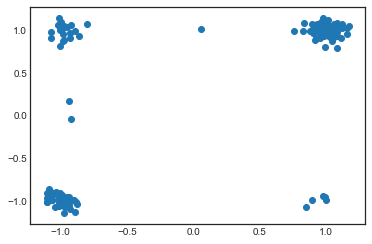

In [178]:
outputs.index('max_r') 
p = pd.DataFrame(y_pred['DNN'],columns=outputs)
r = pd.DataFrame(y_test,columns=outputs).rename(lambda x: x+'_test',axis='columns')
count_CC(list(p['max_r']),list(r['max_r_test']))

plt.scatter(map(ff,list(p['max_r'])),map(ff,list(r['max_r_test'])))

In [179]:
idx = outputs.index('max_r') 
count_CC(y_pred['DNN'][:,idx],
         y_test[:,idx])

count_CC(ouput_de_normlizer(y_pred['DNN'])[:,0], ouput_de_normlizer(y_test)[:,0])

count_CC(ouput_de_normlizer(y_pred['DNN'])[:,1], ouput_de_normlizer(y_test)[:,1])


{'DD': 0, 'DU': 0, 'UD': 0, 'UU': 0.8588235294117628}

In [72]:
def ff(x):
    c =15.0
    if x>.005:
        return 1+np.random.normal()/c
    elif x<-.005:
        return -1+np.random.normal()/c
    else:
        return np.random.normal()/c
    

In [180]:
def count_CC(x,y, threshold =.002):
    delta = threshold
    N=len(x)
    result = {'UU':0,'UD':0,'DU':0,'DD':0}
    for i in range(len(x)):
        if (x[i] > delta ) and (y[i]> delta):
            result['UU'] +=1.0/N
        if (x[i] > delta ) and (y[i]< -delta):
            result['UD'] +=1.0/N
        if (x[i] < -delta ) and (y[i]> delta):
            result['DU'] +=1.0/N
        if (x[i] < -delta ) and (y[i]<- delta):
            result['DD'] +=1.0/N
    accuracy = (result['UU']+result['DD'])/(sum(result.values()))
    return result
    

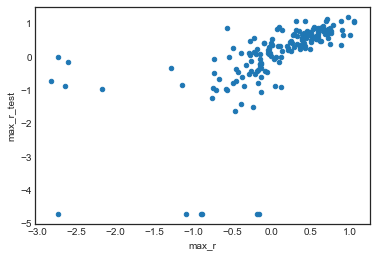

In [252]:
pd.concat([p[['max_r','min_r']],r[['max_r_test','min_r_test']]],axis=1).plot.scatter('max_r','max_r_test')

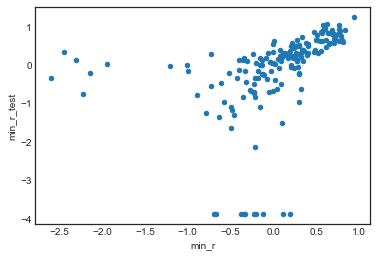

In [253]:
pd.concat([p[['max_r','min_r']],r[['max_r_test','min_r_test']]],axis=1).plot.scatter('min_r','min_r_test')

In [183]:
p = pd.DataFrame(y_pred['Crude Average'],columns=outputs)
r = pd.DataFrame(y_test,columns=outputs).rename(lambda x: x+'_test',axis='columns')
#plt.scatter(map(ff,list(p['daily_r'])),map(ff,list(r['daily_r_test'])))
rr = pd.concat([p[['max_r','min_r']],r[['max_r_test','min_r_test']]],axis=1)
(abs((rr['max_r']-rr['max_r_test']))).describe()

KeyError: 'Crude Average'

In [77]:
p = pd.DataFrame(y_pred['DNN'],columns=outputs)
r = pd.DataFrame(y_test,columns=outputs).rename(lambda x: x+'_test',axis='columns')
#plt.scatter(map(ff,list(p['daily_r'])),map(ff,list(r['daily_r_test'])))
rr = pd.concat([p[['max_r','min_r']],r[['max_r_test','min_r_test']]],axis=1)
(abs((rr['max_r']-rr['max_r_test']))).describe()

count    170.000000
mean       0.336848
std        0.453913
min        0.002722
25%        0.075238
50%        0.218104
75%        0.417285
max        4.396992
dtype: float64

In [188]:
import statsmodels.api as sm

In [44]:
results = sm.OLS((np.array(pd.DataFrame(y_train)[0])) , pd.DataFrame(X_train,columns=inputs)['Open_gush']).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     9.481
Date:                Mon, 10 Dec 2018   Prob (F-statistic):            0.00224
Time:                        17:17:27   Log-Likelihood:                -496.93
No. Observations:                 343   AIC:                             995.9
Df Residuals:                     342   BIC:                             999.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Open_gush     -0.1775      0.058     -3.079      0.0

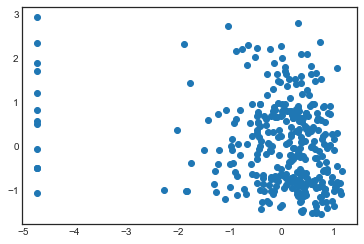

In [190]:
plt.plot((np.array(pd.DataFrame(y_train)[0])) , pd.DataFrame(X_train,columns=inputs)['Open_gush'],'o')

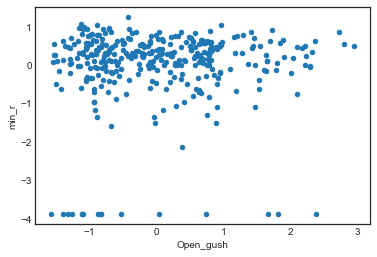

In [191]:
pd.concat([pd.DataFrame(y_train,columns=outputs) , pd.DataFrame(X_train,columns=inputs)['Open_gush']],axis=1).plot.scatter('Open_gush','min_r'
                        )

In [239]:
inputs

['Open_oil',
 'lag4_gush',
 'Volume_oil',
 'Low_oil',
 'lag2_gush',
 'High_gush',
 'Close_oil',
 'daily_r',
 'Close_gush',
 'lag1_gush',
 'Low_gush',
 'High_oil',
 'Volume_gush',
 'intra_r',
 'lag3_gush',
 'Open_gush']